# Data pre-processing

## Imports

In [218]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from functions import sig, alter_sig, sigfit, alter_sigfit
pd.options.mode.chained_assignment = None # Stop seeing warnings

## Load data

### Load Demographic data

In [219]:
sheet_url = "https://docs.google.com/spreadsheets/d/1H9DApYyqdZ0iVAvFKBodHrH654K0NwKzldf5xz5m2tc/edit#gid=1885121359"
url_demographic = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_demographic = pd.read_csv(url_demographic)
data_demographic

,Marca temporal,Código de participante,He sido informado sobre la naturaleza del estudio y doy mi consentimiento para participar:,Sexo,Edad (en años),Nivel educativo,Ocupación,¿Eres beneficiario de alguna beca académica? ¿Cuál?,"¿Has sido diagnosticada/o con alguna de las siguientes condiciones? (De ser así, por favor marca las opciones correspondientes).",¿Presentas problemas de visión sin corregir?,...,"2. Por lo general me concentro más en ""la imagen completa"", en lugar de en los pequeños detalles.",3. Me resulta fácil hacer más de una cosa a la vez.,"4. Si hay una interrupción, puedo volver a concentrarme en lo que estaba haciendo muy rápido.","5. Me resulta fácil ""leer entre líneas"" cuando alguien me está hablando.",6. Sé cómo saber si alguien que me escucha se está aburriendo.,"7. Cuando estoy leyendo una historia, me resulta difícil descifrar las intenciones de los personajes.","8. Me gusta recabar información sobre categorías de cosas (por ejemplo: tipos de automóviles, tipos de aves, tipos de trenes, tipos de plantas, etc.)",9. Me resulta fácil saber lo que alguien está pensando o sintiendo simplemente mirando su rostro.,10. Me resulta difícil comprender las intenciones de las personas.,"¿Tienes historial de trastornos neurológicos? (Ejem. afasia, dislexia, etc.)"
0,30/1/2024 10:34:23,P01,NaN,Femenino,23,Universitario incompleto,Universitaria,NaN,No,No,...,4.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,3.0,No
1,30/1/2024 12:30:34,P02,NaN,Femenino,21,Universitario incompleto,estudiante,NaN,Trastorno de Déficit de Atención,No,...,1.0,4.0,3.0,1.0,2.0,1.0,4.0,4.0,4.0,Si
2,30/1/2024 14:13:03,P03,NaN,Masculino,21,Universitario incompleto,Estudiante,NaN,No,Si,...,2.0,4.0,2.0,2.0,4.0,3.0,4.0,3.0,3.0,No
3,30/1/2024 15:33:06,P04,NaN,Masculino,21,Universitario incompleto,Estudiante,NaN,Trastorno del Espectro Autista,No,...,1.0,1.0,2.0,2.0,3.0,1.0,4.0,2.0,4.0,No
4,13/3/2024 16:33:02,A01,NaN,SEMIHOMBRE,21,Universitario incompleto,ESTUDIANTE,NaN,No,Si,...,3.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,2.0,No
5,13/3/2024 16:55:09,A02,NaN,Femenino,20,Universitario incompleto,estudiante,NaN,No,Si,...,3.0,3.0,2.0,2.0,2.0,1.0,2.0,3.0,3.0,No
6,14/3/2024 13:05:59,A03,NaN,Femenino,25,Universitario incompleto,Estudiante,NaN,Trastorno de Déficit de Atención,Si,...,2.0,3.0,1.0,2.0,3.0,2.0,4.0,3.0,3.0,Si
7,21/3/2024 16:52:02,AC01,Sí,Femenino,17,Universitario incompleto,Estudiante,NaN,No,No,...,2.0,3.0,4.0,3.0,4.0,1.0,4.0,2.0,2.0,No
8,22/3/2024 9:09:53,AC02,Sí,Femenino,16,Universitario incompleto,Estudiante de ingeniería,NaN,No,Si,...,2.0,3.0,4.0,2.0,4.0,2.0,3.0,4.0,2.0,No
9,22/3/2024 9:59:59,AC03,Sí,Femenino,17,Secundaria completa,Estudiante,NaN,No,No,...,2.0,3.0,3.0,2.0,4.0,2.0,2.0,3.0,2.0,No


### Load DFI data

In [220]:
# Get participant files name
participant_files = []
for p in Path("./data_ac").glob("*.csv"):
    participant_files.append(f"{p.name}")

# Create empty DataFrame
data_dfi = pd.DataFrame()

# Compute data for each participant
for participant_file in participant_files:
    data = pd.read_csv("data_ac/" + participant_file)
    data = data[
        [
            "participant",
            "SOA",
            "confidence_slider.response",
            "confidence_slider.rt",
            "key_resp.keys",
            "key_resp.rt",
        ]
    ]
    data = data.dropna()

    par_df = pd.DataFrame()

    for soa in data.SOA.unique():
        soa_df = data.query("SOA == @soa")
        confidence = soa_df["confidence_slider.response"].mean()

        confidence_rt = soa_df["confidence_slider.rt"].mean()
        two_flashes = soa_df[soa_df["key_resp.keys"] == "num_2"].shape[0]
        two_flashes_rt = soa_df["key_resp.rt"].mean()

        par = {
            "Participant": data.participant.iloc[-1],
            "SOA": soa,
            "Confidence": confidence,
            "Illusion_count": two_flashes,
            "Confidence_RT": confidence_rt,
            "Illusion_count_RT": two_flashes_rt,
        }

        new_df = pd.DataFrame(data=par, index=[soa])
        par_df = pd.concat([par_df, new_df], ignore_index=True)

    # Append to final Dataframe
    data_dfi = pd.concat([data_dfi, par_df], ignore_index=True)

data_dfi["SOA"].unique()

array([14., 13., 11.,  6., 12.,  9.,  8.,  4.,  2., 16.,  7.,  3.,  5.,
       10., 15.])

### Load Audiometry data

In [221]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=0"
url_pure_tone = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_pure_tone = pd.read_csv(url_pure_tone)
data_pure_tone

,Participant ID,Ear,Frequency (Hz),Hearing Level (dB),Date,Evaluator
0,AC01,R,1000,20,21/03,Fernando
1,AC01,R,2000,10,21/03,Fernando
2,AC01,R,4000,15,21/03,Fernando
3,AC01,R,8000,5,21/03,Fernando
4,AC01,R,500,20,21/03,Fernando
...,...,...,...,...,...,...
415,AC36,L,2000,0,16/04,Fernando
416,AC36,L,4000,5,16/04,Fernando
417,AC36,L,8000,5,16/04,Fernando
418,AC36,L,500,15,16/04,Fernando


In [222]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=309462883"
url_ldl = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_ldl = pd.read_csv(url_ldl)
data_ldl

,Participant ID,Ear,Frequency (Hz),Start (dB),LDL (dB),Date,Evaluator
0,AC01,L,1000,10,70.0,21/03,Fernando
1,AC01,L,2000,10,70.0,21/03,Fernando
2,AC01,L,4000,15,50.0,21/03,Fernando
3,AC01,L,8000,20,55.0,21/03,Fernando
4,AC01,L,500,10,60.0,21/03,Fernando
...,...,...,...,...,...,...,...
253,AC36,R,2000,0,100.0,16/04,Fernando
254,AC36,R,4000,0,110.0,16/04,Fernando
255,AC36,R,8000,-5,100.0,16/04,Fernando
256,AC36,R,500,15,100.0,16/04,Fernando


## Scales scoring

### Autism Questionnaire calculation

In [223]:
# Revise columns
data_demographic.columns

Index(['Marca temporal', 'Código de participante',
       'He sido informado sobre la naturaleza del estudio y doy mi consentimiento para participar:',
       'Sexo', 'Edad (en años)', 'Nivel educativo', 'Ocupación',
       '¿Eres beneficiario de alguna beca académica? ¿Cuál?',
       '¿Has sido diagnosticada/o con alguna de las siguientes condiciones? (De ser así, por favor marca las opciones correspondientes).',
       '¿Presentas problemas de visión sin corregir?',
       '¿Presentas problemas de audición sin corregir?',
       '¿Tienes algún diagnóstico psiquiátrico?',
       'En caso hayas recibido un diagnostico psiquiátrico, ¿cuál fue?',
       '¿Consumes alguna medicación psiquiátrica?',
       '¿Cuántas horas dormiste anoche?',
       '¿Cuántas horas en promedio has dormido en las últimas dos semanas?',
       '1. Muchas veces noto pequeños sonidos en los que otros no reparan.',
       '2. Por lo general me concentro más en "la imagen completa", en lugar de en los pequeños det

In [224]:
# Only keep columns corresponding to the scale 
autism_scale_cols = ['Código de participante','1. Muchas veces noto pequeños sonidos en los que otros no reparan.',
       '2. Por lo general me concentro más en "la imagen completa", en lugar de en los pequeños detalles.',
       '3. Me resulta fácil hacer más de una cosa a la vez.',
       '4. Si hay una interrupción, puedo volver a concentrarme en lo que estaba haciendo muy rápido.',
       '5. Me resulta fácil "leer entre líneas" cuando alguien me está hablando.',
       '6. Sé cómo saber si alguien que me escucha se está aburriendo.',
       '7. Cuando estoy leyendo una historia, me resulta difícil descifrar las intenciones de los personajes.',
       '8. Me gusta recabar información sobre categorías de cosas (por ejemplo: tipos de automóviles, tipos de aves, tipos de trenes, tipos de plantas, etc.)',
       '9. Me resulta fácil saber lo que alguien está pensando o sintiendo simplemente mirando su rostro.',
       '10. Me resulta difícil comprender las intenciones de las personas.']
data_demographic_autism = data_demographic[autism_scale_cols]

# Rename columns so it's easier to handle
data_demographic_autism.columns = ['Código de participante','AQ_1','AQ_2','AQ_3','AQ_4',
                                                      'AQ_5','AQ_6','AQ_7','AQ_8','AQ_9','AQ_10']

How to manage scoring (Beatriz, 2020):

Each item can have a score of 0 or 1:  
1) Score 1 if the person selected 3 and 4 in items 1,7,8 and 10
2) Score 0 if the person has selected the options 1 and 2 in items 2,3,4,5,6 and 9
Subsequently, sum all obtained punctuations.

3) If the total score is within 6 and 10, consider refering to a specialized diagnosis and intervention center (cutting point for "meeting criteria")


In [225]:
data_demographic_autism.dropna(inplace=True) # Remove participants with NaN values in this scale, as having any NaN values would mess up the scoring

In [226]:
# Step 1)
data_demographic_autism['AQ_1'] = np.where(data_demographic_autism['AQ_1'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_7'] = np.where(data_demographic_autism['AQ_7'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_8'] = np.where(data_demographic_autism['AQ_8'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_10'] = np.where(data_demographic_autism['AQ_10'].isin([3.0, 4.0]), 1,0)

# Step 2)
data_demographic_autism['AQ_2'] = np.where(data_demographic_autism['AQ_2'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_3'] = np.where(data_demographic_autism['AQ_3'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_4'] = np.where(data_demographic_autism['AQ_4'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_5'] = np.where(data_demographic_autism['AQ_5'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_6'] = np.where(data_demographic_autism['AQ_6'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_9'] = np.where(data_demographic_autism['AQ_9'].isin([1.0, 2.0]), 0,1)


In [227]:
# Sum all values
data_demographic_autism["AQ_TOTAL"] = data_demographic_autism.iloc[:,:-1].sum(axis=1, numeric_only=True)

In [228]:
# Step 3)
data_demographic_autism['AQ_MC'] = np.where(data_demographic_autism['AQ_TOTAL'].ge(6),1, 0) #Autism Questionnaire Meets Criteria -> 0: No, 1: Yes


df_aq = data_demographic_autism[["Código de participante", "AQ_TOTAL", "AQ_MC"]]
df_aq.head()

,Código de participante,AQ_TOTAL,AQ_MC
0,P01,6,1
1,P02,4,0
2,P03,6,1
3,P04,3,0
4,A01,6,1


## SOA stuff

### Obtain OPI
Important info: 
- There are 16 SOAs | is this true? is it 16 or 17? Ask
- Each SOA is shown 10 times

In [229]:
participant_codes = data_dfi.Participant.unique()
participant_codes

array(['ac24', 'AC27', 'AC37', 'AC08', 'AC30', 'AC17', 'AC38', 'AC33',
       'AC34', 'AC07', 'AC31', 'AC12', 'AC01', 'AC32', 'AC20', 'AC35',
       'AC21', 'AC25', 'AC24', 20242321.0, 20232404.0, 'AC03', 'AC04',
       'AC15', 'AC39', 'ac13', 'AC22', 'AC23', 'AC36', 498963.0, 'AC19',
       'AC28', 'AC14', 'AC05', 'AC16', 'AC02', 'AC11', 'AC06'],
      dtype=object)

In [230]:
# Add column with information of all ilussions ocurred - Fill it with empty values
data_dfi["Total_i_count"] = np.nan

In [231]:
# Test for one participant
code = "AC35" # Select the participant
total_i_count = data_dfi[data_dfi.Participant == code]["Illusion_count"].sum() # Count number of ilussions across SOAs
print("Total count for the participant", total_i_count)

data_dfi['Total_i_count'] = data_dfi['Total_i_count'].where(data_dfi['Participant'].ne(code), 
                                     total_i_count) # Change Total_i_count column; should match total_i_count variable
data_dfi[data_dfi.Participant == code]

Total count for the participant 0


,Participant,SOA,Confidence,Illusion_count,Confidence_RT,Illusion_count_RT,Total_i_count
225,AC35,9.0,94.896,0,2.854111,1.120261,0.0
226,AC35,6.0,80.947,0,1.046388,1.520515,0.0
227,AC35,14.0,93.032,0,0.816518,1.262013,0.0
228,AC35,7.0,88.823,0,1.387887,1.422564,0.0
229,AC35,12.0,88.865,0,0.811570,1.184451,0.0
230,AC35,10.0,82.023,0,1.291704,1.171406,0.0
231,AC35,13.0,91.979,0,0.948326,1.364021,0.0
232,AC35,11.0,84.917,0,1.314888,1.065978,0.0
233,AC35,3.0,93.771,0,0.788438,1.614316,0.0
234,AC35,4.0,84.907,0,1.019649,2.051213,0.0


They match. Now to generalize across all participants

In [232]:
for code in participant_codes:
    total_i_count = data_dfi[data_dfi.Participant == code]["Illusion_count"].sum() # Count number of ilussions across SOAs
    data_dfi['Total_i_count'] = data_dfi['Total_i_count'].where(data_dfi['Participant'].ne(code), 
                                                                total_i_count) # Change Total_i_count column; should match total_i_count variable

### Sigmoid fit to obtain TW

In [233]:
tw_all = []
illusions_count_all = []
for code in participant_codes:
    participant_data = data_dfi[data_dfi.Participant == code].sort_values("SOA")
    illussion_count = participant_data["Total_i_count"].tolist()[0]
    participant_twi = np.nan

    if illussion_count > 0: # Only run if there was at least one occurence of the illusion
        participant_data_illusion = participant_data.Illusion_count.values * 10
        soas = participant_data.SOA.values * 17

        # Main fitting procedure
        a, b, participant_twi, participant_slope = sigfit(soas, participant_data_illusion)
        participant_sigmoid_data = sig(soas, a, b, participant_twi, participant_slope)
        
    tw_all.append(participant_twi)
    illusions_count_all.append(illussion_count)

        #plt.scatter(soas, participant_data_illusion)
        #plt.plot(soas, participant_sigmoid_data)
        #plt.show()

/Users/camilamaura/Coding projects/GIFTED-DFI/functions.py:16: RuntimeWarning: overflow encountered in exp
  return a + b / (1 + np.exp(-(x - c) / d))


In [240]:
# Calculate OPI -> # illusions / # trials
n_soas = 15 # It's 15 SOA
n_repetitions = 10 # Each SOA is presented 10 times
n_trials = n_repetitions*n_soas
opi_all = np.array(illusions_count_all)/n_trials

In [247]:
# Create DFI dataset
df_dfi = pd.DataFrame(list(zip(participant_codes, tw_all, opi_all)),
               columns =['Código de participante', 'TW', "OPI"])
df_dfi.head(5)

,Código de participante,TW,OPI
0,ac24,NaN,0.000000
1,AC27,147.021532,0.513333
2,AC37,191.220676,0.553333
3,AC08,114.249867,0.306667
4,AC30,175.928944,0.406667


## General dataset

- Código de participante : Código de participante

- TWI : Inflection point (centre) of fitted sigmoid, considered as the amplitude of the window within which the illusion was experienced
- OPI : # illusions / # trials

- AQ_TOTAL : Total score in Autism Questionnaire
- AQ_MC : Bool meets criteria for clinical evaluation of autism

In [246]:
df = pd.merge(df_dfi,df_aq, on = "Código de participante",how="left")
df.head(5)

,Código de participante,TW,OPI,AQ_TOTAL,AQ_MC
0,ac24,NaN,0.000000,NaN,NaN
1,AC27,147.021532,0.513333,7.0,1.0
2,AC37,191.220676,0.553333,5.0,0.0
3,AC08,114.249867,0.306667,3.0,0.0
4,AC30,175.928944,0.406667,4.0,0.0


## Group Results

<Axes: xlabel='SOA', ylabel='Illusion_count'>

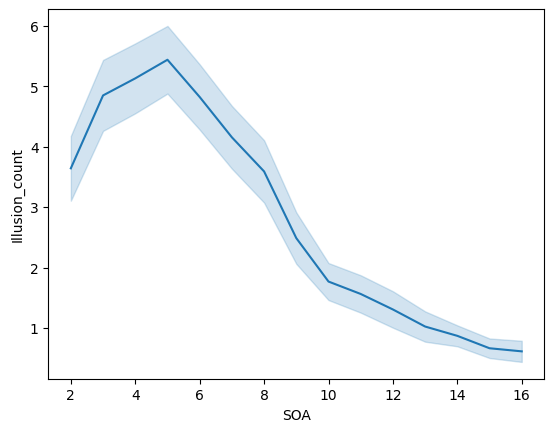

In [237]:
sns.lineplot(x="SOA", y="Illusion_count", data=data_dfi, errorbar="se")